In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

# === Load data ===
prices_day_0 = pd.read_csv("prices_round_3_day_0.csv", sep=";")
prices_day_1 = pd.read_csv("prices_round_3_day_1.csv", sep=";")
prices_day_2 = pd.read_csv("prices_round_3_day_2.csv", sep=";")

all_prices = pd.concat([prices_day_0, prices_day_1, prices_day_2], ignore_index=True)

# === Filter relevant rows ===
spot = all_prices[all_prices["product"] == "VOLCANIC_ROCK"]
options = all_prices[all_prices["product"].str.startswith("VOLCANIC_ROCK_VOUCHER")].copy()

# === Extract strike price from product name ===
options["strike"] = options["product"].str.extract(r'(\d+)', expand=False).astype(float)

# === Merge in spot price ===
spot = spot[["day", "timestamp", "mid_price"]].rename(columns={"mid_price": "spot_price"})
options = pd.merge(options, spot, on=["day", "timestamp"], how="left")

# === Black-Scholes model ===
def bs_call_price(S, K, T, r, sigma):
    if sigma == 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + sigma**2 / 2.) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_volatility_call(market_price, S, K, T, r):
    try:
        return brentq(lambda sigma: bs_call_price(S, K, T, r, sigma) - market_price, 1e-6, 5.0)
    except ValueError:
        return np.nan

# === Compute implied volatilities ===
T = 7 / 365  # 7 days to expiry
r = 0

options["implied_vol"] = options.apply(
    lambda row: implied_volatility_call(row["mid_price"], row["spot_price"], row["strike"], T, r),
    axis=1
)

# === Aggregate results ===
summary = options.groupby("product")["implied_vol"].mean().reset_index()
summary.columns = ["Option", "Mean Implied Volatility"]

overall = options["implied_vol"].mean()
summary.loc[len(summary.index)] = ["ALL_OPTIONS", overall]

# === Display final summary ===
print(summary)


                        Option  Mean Implied Volatility
0  VOLCANIC_ROCK_VOUCHER_10000                 0.158185
1  VOLCANIC_ROCK_VOUCHER_10250                 0.147814
2  VOLCANIC_ROCK_VOUCHER_10500                 0.150364
3   VOLCANIC_ROCK_VOUCHER_9500                 0.136681
4   VOLCANIC_ROCK_VOUCHER_9750                 0.168812
5                  ALL_OPTIONS                 0.152408


In [5]:
# use historical log returns to compute the volatility
# 10000 rows(timesteps) equal to 1 day of data
timesteps_per_day = 1000000

def get_historical_volatility(prices: pd.DataFrame, window_size=7):
    # Calculate log returns

    log_returns = np.log(prices / prices.shift(1)).dropna()

    # Calculate rolling volatility
    rolling_volatility = log_returns.rolling(window=window_size).std()
    #  Annualize the volatility, 10000 rows per day, 252 days in a year
    annualized_volatility = rolling_volatility * np.sqrt(10000 * 252)
    return annualized_volatility

# === Calculate historical volatility ===


In [18]:
historical_spot_vol = spot.copy()
historical_spot_vol["historical_vol"] = get_historical_volatility(historical_spot_vol["spot_price"], window_size=100)
historical_spot_vol = historical_spot_vol.dropna(subset=["historical_vol"])

historical_spot_vol['T'] = (7 * timesteps_per_day - (timesteps_per_day * 3 + historical_spot_vol['timestamp']))/(timesteps_per_day * 7)


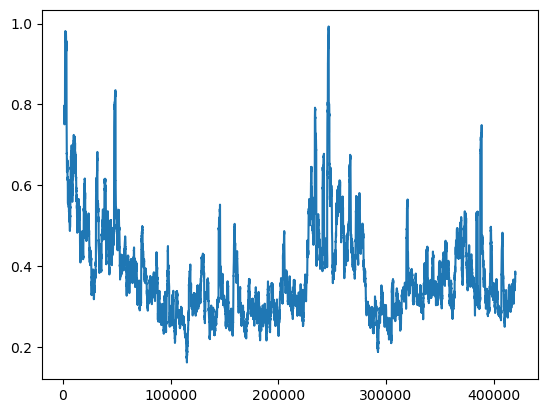

In [19]:
import matplotlib.pyplot as plt
plt.plot(historical_spot_vol['historical_vol'], label='Historical Volatility')
plt.show()

In [25]:
# apply AR(1) to the historical volatility to get the forecasted volatility
def fit_ar1(vol_series):
    y = vol_series[1:]
    x = vol_series[:-1]
    beta = np.dot(x, y) / np.dot(x, x)
    alpha = np.mean(y - beta * x)
    return alpha, beta

def forecast_next_vol(current_vol, alpha, beta):
    return alpha + beta * current_vol

def forecast_ar1_multi_step(current_vol, alpha, beta, h):
    """
    Forecast h steps ahead using AR(1).
    """
    if beta == 1:
        return current_vol + h * alpha  # random walk case
    return alpha * (1 - beta ** h) / (1 - beta) + (beta ** h) * current_vol

10-step Pearson correlation: 0.9706


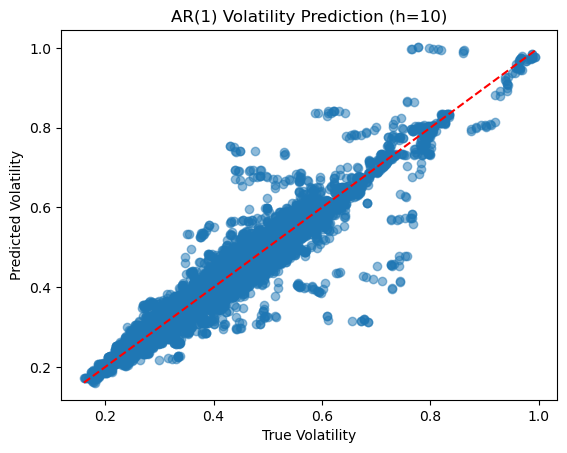

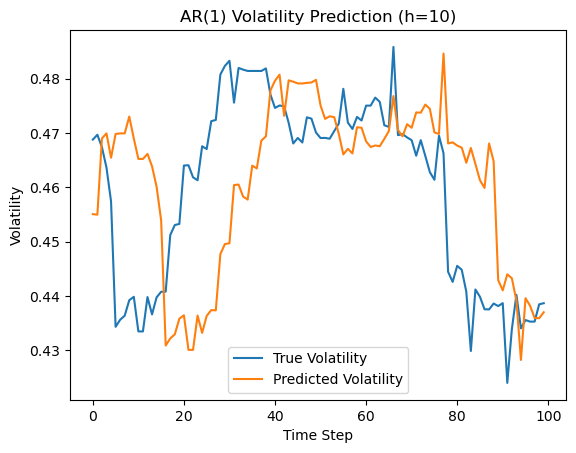

In [39]:
pred = []
true = []
forecast_horizon = 10
window_size = 1000
vol_series = historical_spot_vol['historical_vol'].values

for i in range(window_size, len(vol_series) - forecast_horizon):
    cur_slice = vol_series[i - window_size:i]
    alpha, beta = fit_ar1(cur_slice)
    
    current_vol = cur_slice[-1]
    # Forecast h steps ahead
    next_vol = forecast_ar1_multi_step(current_vol, alpha, beta, forecast_horizon)

    actual_vol = vol_series[i + forecast_horizon]  # shifted by h
    pred.append(next_vol)
    true.append(actual_vol)

# Evaluate prediction quality
from scipy.stats import pearsonr
corr, _ = pearsonr(pred, true)
print(f"{forecast_horizon}-step Pearson correlation: {corr:.4f}")

# Plot scatter plot of predictions vs true values
plt.scatter(true, pred, alpha=0.5)
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.title(f"AR(1) Volatility Prediction (h={forecast_horizon})")
plt.plot([min(true), max(true)], [min(true), max(true)], 'r--')
plt.show()

# plot time series of predictions vs true values
plt.plot(true[100:200], label='True Volatility')
plt.plot(pred[100:200], label='Predicted Volatility')
plt.xlabel("Time Step")
plt.ylabel("Volatility")
plt.legend()
plt.title(f"AR(1) Volatility Prediction (h={forecast_horizon})")
plt.show()


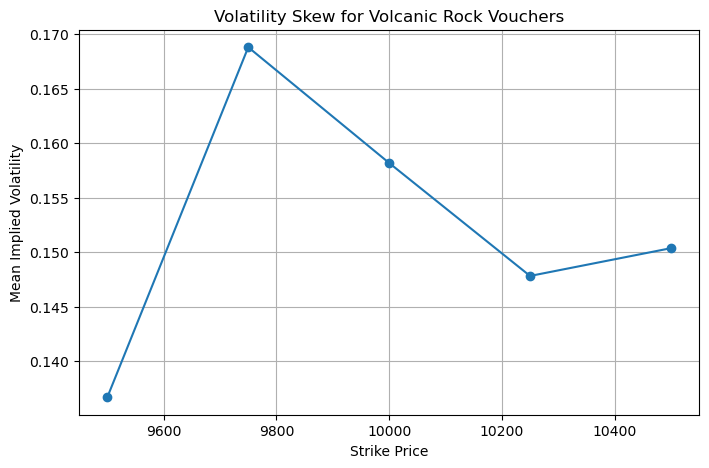

In [4]:
import matplotlib.pyplot as plt

# Sort by strike
skew_data = summary[summary["Option"] != "ALL_OPTIONS"].copy()
skew_data["strike"] = skew_data["Option"].str.extract(r'(\d+)', expand=False).astype(float)
skew_data = skew_data.sort_values("strike")

# Plot volatility skew
plt.figure(figsize=(8, 5))
plt.plot(skew_data["strike"], skew_data["Mean Implied Volatility"], marker='o')
plt.title("Volatility Skew for Volcanic Rock Vouchers")
plt.xlabel("Strike Price")
plt.ylabel("Mean Implied Volatility")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from typing import Tuple

class GaussianHMM:
    def __init__(self, n_states: int = 2):
        self.n_states = n_states
        self.means = np.random.rand(n_states)
        self.stds = np.random.rand(n_states) * 0.1 + 0.01
        self.trans_mat = np.ones((n_states, n_states)) / n_states
        self.init_probs = np.ones(n_states) / n_states

    def gaussian_prob(self, x, mean, std):
        coeff = 1.0 / (std * np.sqrt(2 * np.pi))
        return coeff * np.exp(-0.5 * ((x - mean) / std) ** 2)

    def forward(self, observations: np.ndarray) -> float:
        T = len(observations)
        alpha = np.zeros((T, self.n_states))
        
        # Initialize
        for s in range(self.n_states):
            alpha[0, s] = self.init_probs[s] * self.gaussian_prob(observations[0], self.means[s], self.stds[s])
        
        # Recursion
        for t in range(1, T):
            for s in range(self.n_states):
                prob = self.gaussian_prob(observations[t], self.means[s], self.stds[s])
                alpha[t, s] = prob * np.sum(alpha[t-1] * self.trans_mat[:, s])
        
        # Termination
        return np.sum(alpha[-1])

    def viterbi(self, observations: np.ndarray) -> np.ndarray:
        T = len(observations)
        delta = np.zeros((T, self.n_states))
        psi = np.zeros((T, self.n_states), dtype=int)
        
        # Initialize
        for s in range(self.n_states):
            delta[0, s] = self.init_probs[s] * self.gaussian_prob(observations[0], self.means[s], self.stds[s])
        
        # Recursion
        for t in range(1, T):
            for s in range(self.n_states):
                trans_probs = delta[t-1] * self.trans_mat[:, s]
                psi[t, s] = np.argmax(trans_probs)
                delta[t, s] = np.max(trans_probs) * self.gaussian_prob(observations[t], self.means[s], self.stds[s])
        
        # Backtracking
        path = np.zeros(T, dtype=int)
        path[-1] = np.argmax(delta[-1])
        for t in range(T-2, -1, -1):
            path[t] = psi[t+1, path[t+1]]
        
        return path


Sequence log-likelihood: -inf


C:\Users\Siwoo\AppData\Local\Temp\ipykernel_20336\504447911.py:6: RuntimeWarning: divide by zero encountered in log
  print("Sequence log-likelihood:", np.log(likelihood))


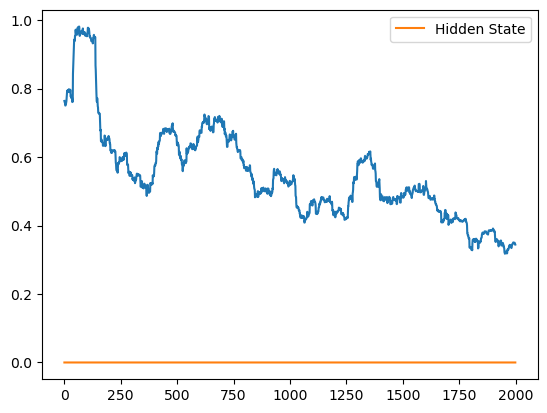

In [42]:
vol_series = historical_spot_vol['historical_vol'].values
hmm = GaussianHMM(n_states=2)

# Evaluate likelihood
likelihood = hmm.forward(vol_series[:2000])
print("Sequence log-likelihood:", np.log(likelihood))

# Infer hidden state path
states = hmm.viterbi(vol_series[:2000])
plt.plot(vol_series[:2000])
plt.plot(states * max(vol_series), label='Hidden State')
plt.legend()
